In [1]:
import math
from random import *

import cv2
import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

_X = []
_y = []
_start = int(30 / 0.6)
_end = int(150 / 0.6)
_scale_div = 10


def format_line(line):
    line = line.replace("[", "")
    line = line.replace("]", "")
    list = line.split(",")
    d_list = []
    for l in list:
        d_list.append(int(l))
    return d_list


def open_log(file_name):
    global _X, _y
    file = open(file_name)
    if file:
        lines = file.readlines()
        x = []
        y = []
        for line in lines:
            data = format_line(line)
            x.append(data[1:])
            y.append(data[0])
        file.close()
        _X = np.array(x)
        _y = np.array(y)
        print(_X.shape)
        print(_y.shape)


def flip_h(x, y):
    x1 = np.flip(x[:, :300], axis=1)
    x2 = np.flip(x[:, 300:], axis=1)
    y1 = -y
    return np.concatenate((x1, x2), axis=1), y1


open_log("train_01.log")

(3085, 600)
(3085,)


In [2]:
_y = _y / 45
_y = np.round(_y)
min(_y), max(_y)

(1.0, -1.0)

In [3]:
aug_x, aug_y = flip_h(_X, _y)

In [4]:
_X = np.concatenate((_X, aug_x))
_y = np.concatenate((_y, aug_y))
print(_X.shape, _y.shape)

(6170, 600) (6170,)


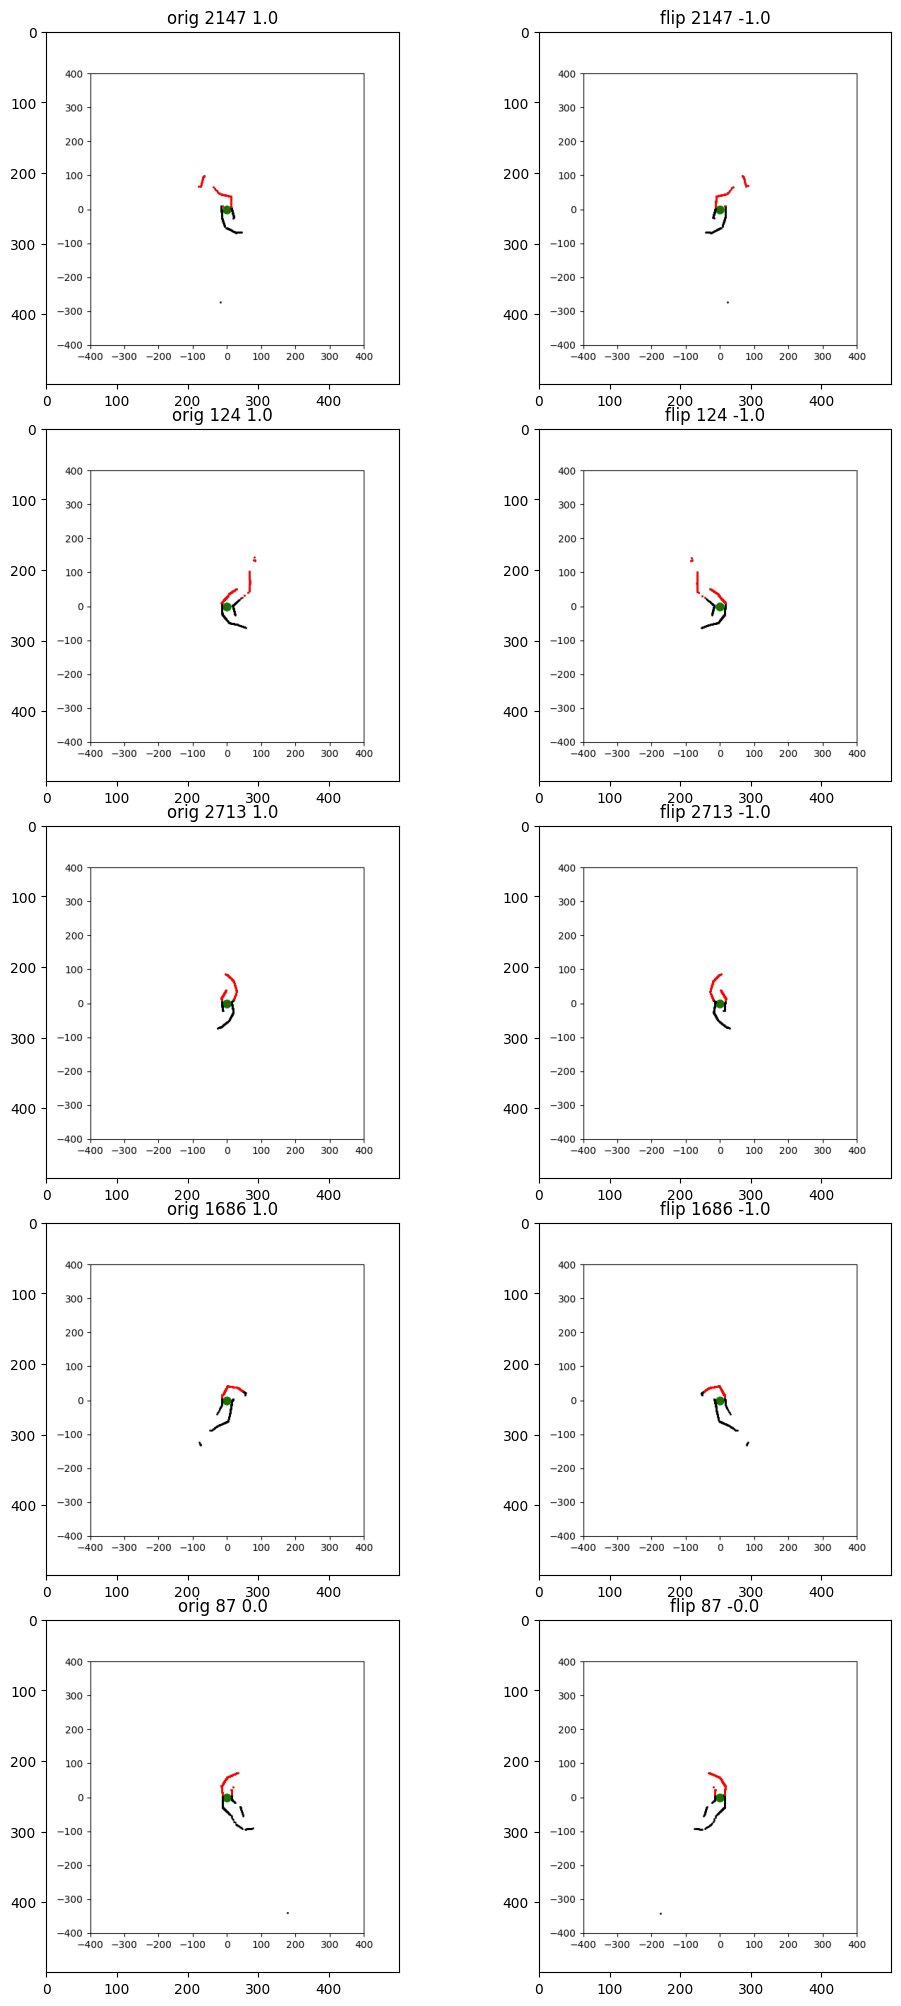

In [62]:
def get_lidar_image(frame):
    fig = plt.figure(figsize=(5, 5))
    plt.clf()
    plt.autoscale(False)
    plt.plot(0, 0, "go", markersize=8)
    # plt.axvline(0, color="g", ls="--")
    # plt.axhline(0, color="g", ls="--")
    lim = 4000 / _scale_div
    plt.xlim([-lim, lim])
    plt.ylim([-lim, lim])

    angle_res = 0.6
    start = int(0 / angle_res)
    end = int(360 / angle_res)

    roi_start = int(30 / angle_res)
    roi_end = int(150 / angle_res)

    # draw lidar image
    xlist = []
    ylist = []
    for i in range(start, end, 1):
        theta = 180 - (angle_res * i)  # lidar installed with -90 degree and rotate CW
        dist = frame[i] / _scale_div  # but screen coordinates CCW so 180 -
        x = dist * math.cos(math.radians(theta))
        y = dist * math.sin(math.radians(theta))  # screen y is reversed
        xlist.append(x)
        ylist.append(y)
    plt.plot(xlist, ylist, "o", markersize=1, color="black")
    plt.plot(xlist[roi_start:roi_end], ylist[roi_start:roi_end], "o", markersize=1, color="red")

    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    # plt.imshow(img)
    # print(f"{angle:3d}")
    return img


fig, axes = plt.subplots(5, 2, figsize=(10, 20))
fig.tight_layout()
for x in range(5):
    i = randint(0, len(aug_x))
    axes[x][0].imshow(get_lidar_image(_X[i]))
    axes[x][0].set_title(f"orig {i} {_y[i]}")
    axes[x][1].imshow(get_lidar_image(aug_x[i]))
    axes[x][1].set_title(f"flip {i} {aug_y[i]}")

(array([1788., 2594., 1788.]),
 array([-1.        , -0.33333333,  0.33333333,  1.        ]),
 <BarContainer object of 3 artists>)

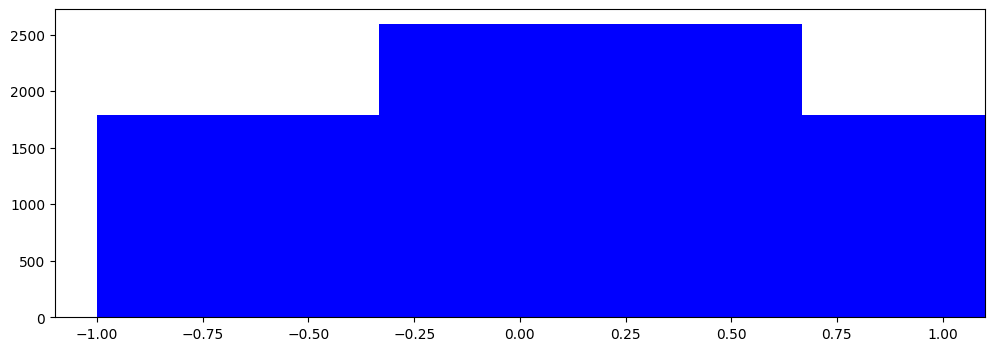

In [25]:
num_of_bins = 3
hist, bins = np.histogram(_y, num_of_bins)
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes.hist(_y, bins=num_of_bins, width=1, color="blue")

## Training

In [26]:
label_encoder = LabelEncoder()
label_y = label_encoder.fit_transform(_y)
print(label_y.shape)

(6170,)


In [102]:
X_train, X_test, y_train, y_test = train_test_split(_X, label_y, test_size=0.2, random_state=42)

k_best = SelectKBest(score_func=f_classif, k=30)
k_best.fit(X_train, y_train)
selected_feature_indices = k_best.get_support(indices=True)
print("selected_feature_indices: ", selected_feature_indices)
angles = selected_feature_indices * 0.6
print("selected_feature_angles : ", angles)

clf = RandomForestClassifier(max_depth=60, random_state=42, n_estimators=100, criterion="gini")
# X_train_lim = X_train[:, _start:_end]
X_train_lim = X_train[:, selected_feature_indices]
clf.fit(X_train_lim, y_train)

# X_test_lim = X_test[:, _start:_end]
X_test_lim = X_test[:, selected_feature_indices]
y_pred = clf.predict(X_test_lim)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

selected_feature_indices:  [ 66  68  70  78  79  80  81  82  83  84  85  87  89 210 212 214 215 216
 217 218 219 220 221 222 228 229 231 232 233 237]
selected_feature_angles :  [ 39.6  40.8  42.   46.8  47.4  48.   48.6  49.2  49.8  50.4  51.   52.2
  53.4 126.  127.2 128.4 129.  129.6 130.2 130.8 131.4 132.  132.6 133.2
 136.8 137.4 138.6 139.2 139.8 142.2]
Accuracy: 0.7212317666126418


In [103]:
print(_X.shape)
t = clf.predict(_X[87, selected_feature_indices].reshape(-1, 30))
print(t)

(6170, 600)
[1]


In [91]:
class_names = []
for c in label_encoder.classes_:
    class_names.append(str(c))
print(y_pred.shape)
print(y_test.shape)
print(len(class_names))
print(class_names)

report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)
print("Classification Report:\n", report)

(1234,)
(1234,)
3
['-1.0', '-0.0', '1.0']
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.73      0.79      0.76       335
        -0.0       0.71      0.64      0.67       549
         1.0       0.73      0.78      0.75       350

    accuracy                           0.72      1234
   macro avg       0.72      0.74      0.73      1234
weighted avg       0.72      0.72      0.72      1234



In [79]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(
    n_estimators=500, criterion="squared_error", random_state=42, n_jobs=-1
)
forest.fit(X_train_lim, y_train)

from sklearn.metrics import mean_squared_error, r2_score

X_test_lim = X_test[:, selected_feature_indices]
y_train_pred = forest.predict(X_train_lim)
y_test_pred = forest.predict(X_test_lim)

print(
    f"train MSE:{mean_squared_error(y_train, y_train_pred)}, test MSE:{mean_squared_error(y_test, y_test_pred)}"
)

print(f"train R2:{r2_score(y_train, y_train_pred)}, test R2:{r2_score(y_test, y_test_pred)}")

train MSE:0.029654052674230144, test MSE:0.22036854132901135
train R2:0.94936883018183, test R2:0.602909221752173


In [89]:
print(_X.shape)
t = forest.predict(_X[1686, selected_feature_indices].reshape(-1, 30))
print(t)

(6170, 600)
[1.894]


In [44]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10, p=2, metric="minkowski")
knn.fit(X_train_lim, y_train)

X_test_lim = X_test[:, selected_feature_indices]
y_pred = knn.predict(X_test_lim)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6450567260940032
